In [67]:
### Setup

flipangle       = 90
th_MSOLAR       = 1e10
storyfilelist   = readdir(joinpath(@__DIR__, "halostories/"))
box             = "/HydroSims/Magneticum/Box4/uhr_test/"



### Packages

using Printf
using LinearAlgebra
using JLD
using Statistics
using PyCall
using PyPlot
using LaTeXStrings
using Missings
using GadgetIO
using GadgetUnits
using GadgetGalaxies
using Unitful
using UnitfulAstro
using Cosmology



### Spin change histograms

angle_data = Dict(
    "CENTRALS"      => Array{Int64}(undef, 2, 0), 
    "ANGLES"        => Array{Float64}(undef, 0), 
    "M_felix"       => Array{Float64}(undef, 0), 
    "δM_felix"      => Array{Float64}(undef, 0), 
    "M_fromJ"       => Array{Float64}(undef, 0), 
    "δM_fromJ"      => Array{Float64}(undef, 0),
    "REDSHIFT"      => Array{Float64}(undef, 0),
    "LOOKBACKTIME"  => Array{Float64}(undef, 0),
    "BVAL"          => Array{Float64}(undef, 0),
    "STORY_FLIPS"   => Array{Int64}(undef, 0), 
    "STORY_IFILE"   => Array{Int64}(undef, 0), 
    "STORY_BVAL"    => Array{Float64}(undef, 0),
    "I_FILE"        => Array{Int64}(undef, 0), 
    "I_SUB"         => Array{Int64}(undef, 0) )


limit_filelist  = length(storyfilelist)
for i in 1:limit_filelist
    halo_story  = load(joinpath(@__DIR__, "halostories/$(storyfilelist[i])"), "halo_story")
    head        = read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][1]))/sub_$(@sprintf("%03i", halo_story["SNAP"][1]))")
    snapshot    = Snapshot(box, halo_story["SNAP"][1])
    snapshot.snapbase
    snapshot.subbase
    g           = Galaxy(snapshot, halo_story["I_SUB"][1])
    print("$i ")
    #print("$(halo_story["I_SUB"][1]) ? $(get_first_subhalo(get_group(g)).isub)   ")
    if get_first_subhalo(get_group(g)).isub == halo_story["I_SUB"][1]
        angle_data["CENTRALS"] = hcat(angle_data["CENTRALS"], [halo_story["I_SUB"][1], halo_story["ID"]])
        if convert_units_physical_mass(halo_story["M_STARS"][1], head) > th_MSOLAR
            #print("$(convert_units_physical_mass(halo_story["M_STARS"][1], head))   yyy   ")
            spinTOT = Array{Float64}(undef, 3, 0)
            M_comp  = Array{Float64}(undef, 3, 0)
            n_flips = 0
            for ii in length(halo_story["SNAP"]):-1:1
                #if !ismissing(halo_story["J_DM"][1,ii])
                if !ismissing(halo_story["J_STARS"][1,ii])   &&   norm(halo_story["J_STARS"][:,ii]) > 0.
                    #J_tot   = halo_story["J_DM"][:,ii]
                    #M_comp  = [norm(halo_story["J_DM"][:,ii]) / norm(halo_story["j_DM"][:,ii]), 0., 0.]
                    #if !ismissing(halo_story["J_GAS"][1,ii])
                        #J_tot         .+= halo_story["J_GAS"][:,ii]
                        #M_comp[2,end]   = norm(halo_story["J_GAS"][:,ii]) / norm(halo_story["j_GAS"][:,ii])
                    #end
                    #if !ismissing(halo_story["J_STARS"][1,ii])
                    J_tot           = halo_story["J_STARS"][:,ii]
                    spinTOT         = hcat(spinTOT, J_tot ./ norm(J_tot))
                    #@show spinTOT
                        #M_comp[3,end]   = norm(halo_story["J_STARS"][:,ii]) / norm(halo_story["j_STARS"][:,ii])
                    M_comp          = hcat(M_comp, [0., 0., norm(J_tot) / norm(halo_story["j_STARS"][:,ii])])
                    #else
                        #J_tot           = [0.,0.,0.]
                        #M_comp  = hcat(M_comp, [0., 0., 0.])
                    #end
                    head                = read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][ii]))/sub_$(@sprintf("%03i", halo_story["SNAP"][ii]))")
                    #println("$(length(M_comp[3,:])) | $(M_comp[3,end]) | $(convert_units_physical_mass(halo_story["M_STARS"][ii], head)) | ")
                    if length(M_comp[3,:]) > 1   &&   M_comp[3,end] > th_MSOLAR   &&   convert_units_physical_mass(halo_story["M_STARS"][ii], head) > th_MSOLAR
                        #println("$i/$limit_filelist   $ii/$(length(halo_story["SNAP"]))   --- Pass!")
                        angle_data["LOOKBACKTIME"]  = vcat(angle_data["LOOKBACKTIME"], ustrip(lookback_time(cosmology(h=head.h0, OmegaM=head.omega_0), head.z)))
                        angle_data["REDSHIFT"]      = vcat(angle_data["REDSHIFT"], halo_story["REDSHIFT"][ii])
                        angle_data["I_SUB"]         = vcat(angle_data["I_SUB"], halo_story["I_SUB"][ii])
                        angle_data["ANGLES"]        = vcat(angle_data["ANGLES"], acosd((transpose(spinTOT[:,end])*spinTOT[:,end-1])))
                        if angle_data["ANGLES"][end] > flipangle
                            n_flips              += 1
                        end
                        angle_data["M_fromJ"]       = vcat(angle_data["M_fromJ"], sum(M_comp[3,end]))
                        angle_data["δM_fromJ"]      = vcat(angle_data["δM_fromJ"], sum(M_comp[3,end]) - sum(M_comp[3,end-1]))
                        angle_data["M_felix"]       = vcat(angle_data["M_felix"], convert_units_physical_mass(halo_story["M_STARS"][ii], head))
                        angle_data["δM_felix"]      = vcat(angle_data["δM_felix"], convert_units_physical_mass(halo_story["M_STARS"][ii], head)-convert_units_physical_mass(halo_story["M_STARS"][ii+1], head))
                        angle_data["I_FILE"]        = vcat(angle_data["I_FILE"], halo_story["ID"])
                        angle_data["BVAL"]          = vcat(angle_data["BVAL"], halo_story["BVAL"][ii])
                    end
                end
            end
            angle_data["STORY_FLIPS"]    = vcat(angle_data["STORY_FLIPS"], n_flips)
            angle_data["STORY_IFILE"]    = vcat(angle_data["STORY_IFILE"], halo_story["ID"])
            angle_data["STORY_BVAL"]     = vcat(angle_data["STORY_BVAL"], angle_data["BVAL"][end])
        end
    #else
        #print("$(get_first_subhalo(get_group(g)).isub)!=$(halo_story["I_SUB"][1])  $(convert_units_physical_mass(halo_story["M_STARS"][1], head))<$(th_MSOLAR)   ")
    end
end

println("\n\nNow witness the firepower of this fully armed and operational battle station!\n$(size(angle_data["ANGLES"]))")
println("$(size(angle_data["STORY_FLIPS"]))   ---   $(size(angle_data["STORY_IFILE"]))   ---   $(size(angle_data["STORY_BVAL"]))")

save(joinpath(@__DIR__, "angle_data.jld"), 
    "angle_data",   angle_data)

In [68]:
angle_data      = load(joinpath(@__DIR__, "angle_$(flipangle)_data_CENTRALS_MSTARSgt$(th_MSOLAR).jld"), "angle_data")

Dict{String, Array} with 15 entries:
  "I_SUB"         => [0, 0, 0, 466, 671, 656, 715, 719, 733, 742  …  14330, 144…
  "BVAL"          => [-5.3175, -5.28859, -5.48479, -5.12351, -5.82261, -5.7507,…
  "I_FILE"        => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  99, 99, 99, 99, 99, 994,…
  "M_fromJ"       => [7.75752e11, 9.81942e11, 1.08073e12, 1.24801e12, 1.24873e1…
  "STORY_FLIPS"   => [3, 2, 0, 0, 0, 0, 1, 0, 0, 0  …  0, 0, 1, 0, 1, 1, 1, 1, …
  "STORY_BVAL"    => [-5.09325, -5.10478, -4.66732, -4.79986, -4.22154, -4.8268…
  "δM_fromJ"      => [3.76937e11, 2.06191e11, 9.87832e10, 1.67286e11, 7.20241e8…
  "CENTRALS"      => [0 1414 … 16202 22174; 0 1 … 99 994]
  "REDSHIFT"      => [1.70635, 1.47758, 1.32344, 1.17889, 0.994709, 0.962933, 0…
  "ANGLES"        => [10.5283, 155.146, 23.5839, 145.292, 58.0915, 41.2487, 64.…
  "M_felix"       => [9.05997e11, 1.18722e12, 1.30218e12, 1.51193e12, 1.588e12,…
  "LOOKBACKTIME"  => [9.85553, 9.33008, 8.90886, 8.45283, 7.76632, 7.6339, 7.36…
  "STORY_IFILE

In [69]:
println(size(angle_data["BVAL"]))
println(size(angle_data["M_fromJ"]))

(12190,)
(12190,)


In [15]:

old_angle_data  = load(joinpath(@__DIR__, "angle_data_CENTRALS_MSTARgt10.jld"), "angle_data")

Dict{String, Vector{T} where T} with 14 entries:
  "FLIPS"        => [3, 2, 1, 2, 1, 2, 1, 3, 2, 1  …  1, 1, 1, 4, 5, 1, 1, 1, 1…
  "I_SUB"        => [0, 0, 0, 466, 671, 656, 715, 719, 733, 742  …  14330, 1443…
  "BVAL"         => [-5.3175, -5.28859, -5.48479, -5.12351, -5.82261, -5.7507, …
  "I_FILE"       => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  99, 99, 99, 99, 99, 994, …
  "M_fromJ"      => [7.75752e11, 9.81942e11, 1.08073e12, 1.24801e12, 1.24873e12…
  "FLIPS_IFILE"  => [0, 1, 1015, 109, 110, 111, 115, 118, 121, 1211  …  863, 87…
  "δM_fromJ"     => [3.76937e11, 2.06191e11, 9.87832e10, 1.67286e11, 7.20241e8,…
  "REDSHIFT"     => [1.70635, 1.47758, 1.32344, 1.17889, 0.994709, 0.962933, 0.…
  "ANGLES"       => [10.5283, 155.146, 23.5839, 145.292, 58.0915, 41.2487, 64.0…
  "FLIP_YN"      => [0, 1, 0, 1, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0…
  "M_felix"      => [9.05997e11, 1.18722e12, 1.30218e12, 1.51193e12, 1.588e12, …
  "FLIPS_BVAL"   => [-5.09325, -5.10478, -4.20195, -4.52327,

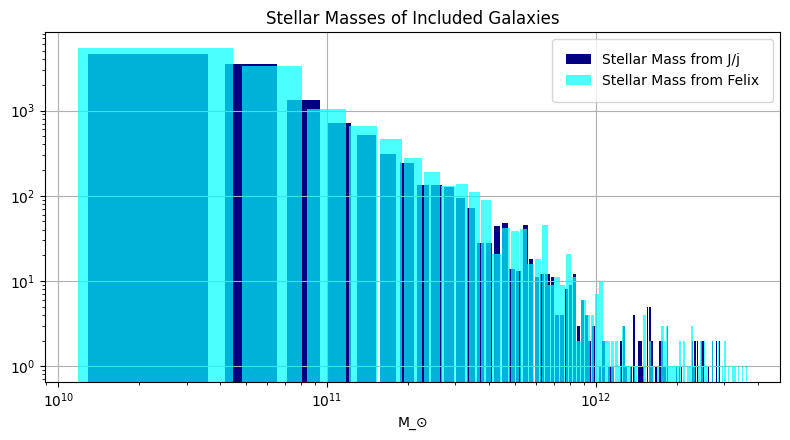

In [70]:
# Plotting the masses

fig, ax = subplots()

ax.hist(angle_data["M_fromJ"], bins=100, label="Stellar Mass from J/j", rwidth=0.8, color="navy", zorder = 1)
ax.hist(angle_data["M_felix"], bins=100, label="Stellar Mass from Felix", rwidth=0.9, color="cyan", alpha= 0.7, zorder = 2)

ax.set_title("Stellar Masses of Included Galaxies")
ax.set_xlabel("M_⊙")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

In [71]:

N_bins = 80
dist_resolution     = 10000

xaxis_angles    = LinRange(0,180,dist_resolution)
all_random      = sind.(xaxis_angles)
all_random    .*= (length(angle_data["ANGLES"]) / sum(all_random) / N_bins * dist_resolution)
@show length(all_random)
@show sum(all_random)
@show length(angle_data["ANGLES"])

length(all_random) = 10000
sum(all_random) = 1.5237500000000005e6
length(angle_data["ANGLES"]) = 12190


12190

In [18]:
#random_angles = rand(0.0:180.0, (length(angle_data["ANGLES"])))
random_angles   = Array{Float64}(undef, 0)
for i in 1:length(angle_data["ANGLES"])
    #print("$i/$(length(angle_data["ANGLES"])) ")
    a = normalize(2*rand(3).-1)
    #@show a
    #a ./= norm(a)
    b = normalize(2*rand(3).-1)
    #@show b
    #b ./= norm(b)
    #random_angles = vcat(random_angles, acosd((transpose(spinTOT[:,end])*spinTOT[:,end-1])))
    random_angles = vcat(random_angles, acosd((transpose(a)*b)))
    #@show random_angles
end
println(size(random_angles))

(12190,)


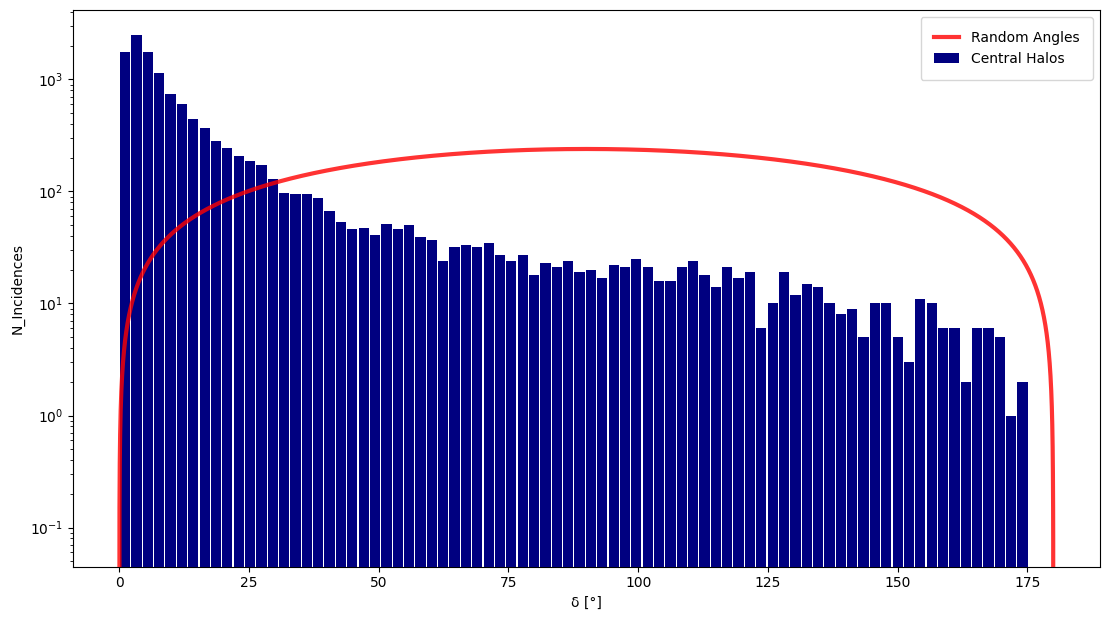

In [75]:
# Plotting the angle histogram

fig, ax = subplots()

#ax.hist(cosd.(random_angles), bins=80, label="Random-Generated", rwidth=0.9, color="cyan", alpha=1, zorder=2)
#ax.hist(cosd.(angle_data["ANGLES"]), bins=80, label="Central Halos M_STAR > 1e10 M⊙", rwidth=0.9, color="navy", alpha=0.8, zorder=3)
#ax.hist(random_angles, bins=80, label="Random Generated", rwidth=0.9, color="cyan", edgecolor="black", alpha=1, zorder=2)
ax.hist(angle_data["ANGLES"], bins=N_bins, label="Central Halos", rwidth=0.9, color="navy", alpha=1, zorder=3)#, edgecolor="black")
ax.plot(xaxis_angles, all_random, "-", lw=3, color="red", label="Random Angles", alpha=0.8, zorder=4)
#ax.plot(xaxis_angles, sind.(xaxis_angles) .* length(angle_data["ANGLES"])./2, "-", lw=2, color="cyan", label="Random Angles", alpha=0.8, zorder=4)
#ax.bar(flipangle, height=3000, label="Flip Angle", color="black", zorder=5)

#ax.set_title("Instant Spin Orientation Change")
ax.set_xlabel("δ [°]")
ax.set_ylabel("N_Incidences")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
#ax.grid()

scale=0.7

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

fig.savefig(joinpath(@__DIR__, "plots/delta_histogram_CENTRAL_MSTARSgt$(th_MSOLAR).png"), bbox_inches="tight", pad_inches=.1)


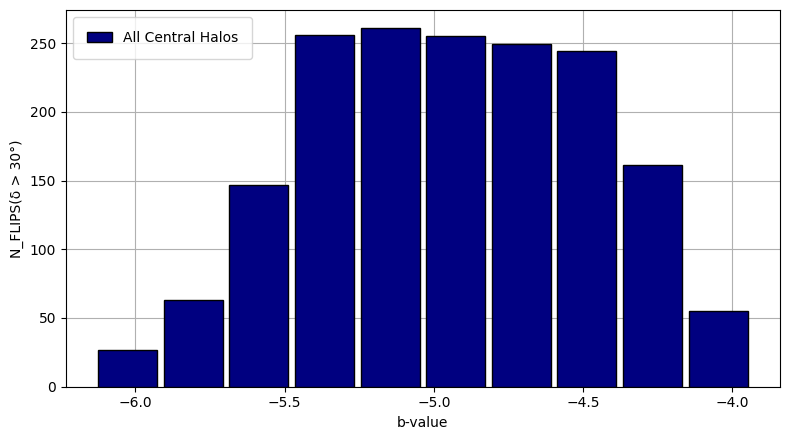

In [20]:
# Plotting the redshift histogram

fig, ax = subplots()

ax.hist(angle_data["STORY_BVAL"], weights=angle_data["STORY_FLIPS"], bins=10, label="All Central Halos", rwidth=0.9, color="navy", edgecolor="black", alpha=1, zorder=3)

#ax.set_title("Short-term Spin Orientation Change")
ax.set_xlabel("b-value")
ax.set_ylabel("N_FLIPS(δ > $(flipangle)°)")
#ax.set_yscale("log")
ax.legend(loc="upper left", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

#fig.savefig(joinpath(@__DIR__, "plots/12345.png"), bbox_inches="tight", pad_inches=.1)

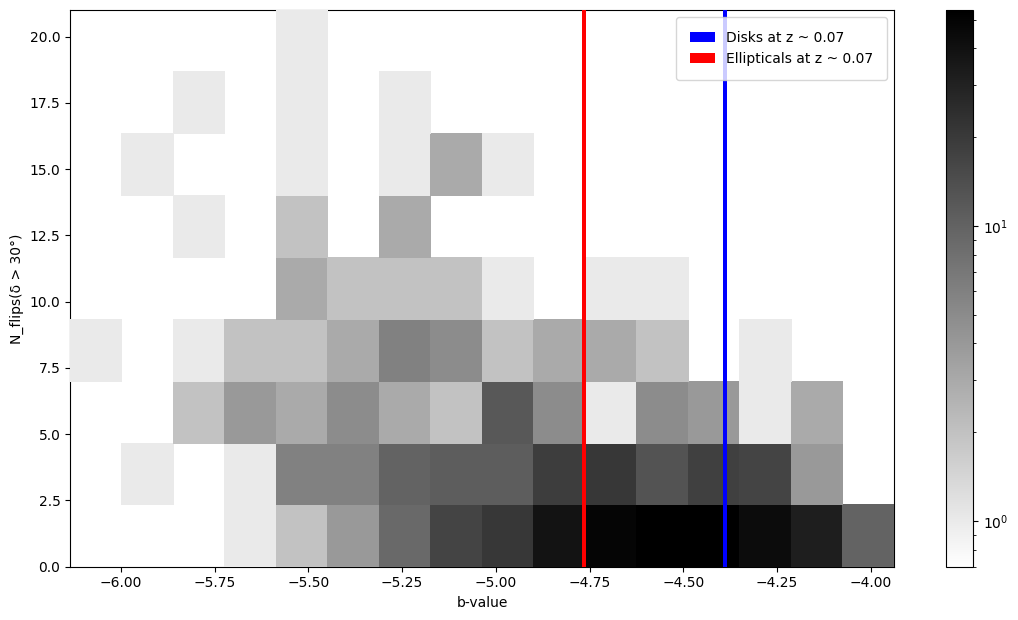

In [21]:
axes_grid1  = pyimport("mpl_toolkits.axes_grid1")
pltcolors   = pyimport("matplotlib.colors")
res_N_FLIP  = 9

head            = read_header("$box/groups_$(@sprintf("%03i", 136))/sub_$(@sprintf("%03i", 136))")
disk_bval_136   = -4.375-0.5*log10(1+head.z)
ell_bval_136    = -4.75-0.5*log10(1+head.z)

fig, ax = subplots()

h = ax.hist2d(angle_data["STORY_BVAL"], angle_data["STORY_FLIPS"], 
    bins=[16, res_N_FLIP], cmap="binary", vmin=0.7, zorder=3, norm=pltcolors.LogNorm())
#h = ax.hist2d(old_angle_data["FLIPS_BVAL"], old_angle_data["FLIPS"], bins=[16, 9], 
    #cmap="gist_yarg", zorder=3, vmin=0)
ax.bar(disk_bval_136, height=maximum(angle_data["STORY_FLIPS"]), 
    width=0.01, color="blue", label="Disks at z ~ $(round.(head.z,digits=2))", zorder=4)
ax.bar(ell_bval_136, height=maximum(angle_data["STORY_FLIPS"]), 
    width=0.01, color="red", label="Ellipticals at z ~ $(round.(head.z,digits=2))", zorder=4)

#ax.set_title("$(length(angle_data["FLIPS"])) Central Halos with J_STAR flips of δ > $flipangle °")
ax.set_xlabel("b-value")
ax.set_ylabel("N_flips(δ > $(flipangle)°)")
#ax.set_ylim(1,maximum(angle_data["STORY_FLIPS"]))
#ax.set_ylim(1,maximum(old_angle_data["FLIPS"]))
#ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
#ax.grid()
fig.colorbar(h[4], ax=ax)

scale=0.7

fig.set_size_inches(16scale, 9*scale)
fig.tight_layout()

#fig.savefig(joinpath(@__DIR__, "plots/nflips_$(flipangle)_bval_CENTRAL_MSTARSgt$(th_MSOLAR).png"), bbox_inches="tight", pad_inches=.1)

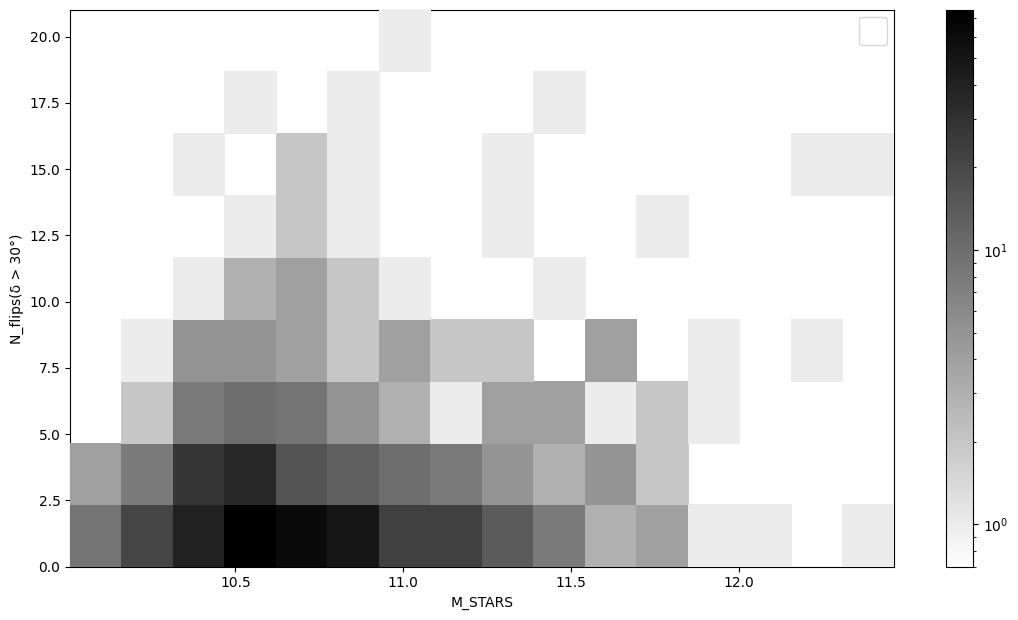

sys:1: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
No handles with labels found to put in legend.


In [22]:
axes_grid1  = pyimport("mpl_toolkits.axes_grid1")
pltcolors   = pyimport("matplotlib.colors")
res_N_FLIP  = 9

fig, ax = subplots()

h = ax.hist2d(log10.(angle_data["STORY_M_fromJ"]), angle_data["STORY_FLIPS"], 
    bins=[16, res_N_FLIP], cmap="binary", vmin=0.7, zorder=3, norm=pltcolors.LogNorm())
#h = ax.hist2d(old_angle_data["FLIPS_BVAL"], old_angle_data["FLIPS"], bins=[16, 9], 
    #cmap="gist_yarg", zorder=3, vmin=0)
#ax.bar(-4.375, height=maximum(angle_data["STORY_FLIPS"]), 
    #width=0.01, color="blue", label="Disks", zorder=4)
#ax.bar(-4.75, height=maximum(angle_data["STORY_FLIPS"]), 
    #width=0.01, color="red", label="Ellipticals", zorder=4)

#ax.set_title("$(length(angle_data["FLIPS"])) Central Halos with J_STAR flips of δ > $flipangle °")
ax.set_xlabel("M_STARS")
ax.set_ylabel("N_flips(δ > $(flipangle)°)")
#ax.set_ylim(1,maximum(angle_data["STORY_FLIPS"]))
#ax.set_ylim(1,maximum(old_angle_data["FLIPS"]))
#ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
#ax.grid()
fig.colorbar(h[4], ax=ax)

scale=0.7

fig.set_size_inches(16scale, 9*scale)
fig.tight_layout()

#fig.savefig(joinpath(@__DIR__, "plots/nflips_$(flipangle)_mass_CENTRAL_MSTARSgt$(th_MSOLAR).png"), bbox_inches="tight", pad_inches=.1)

In [23]:

println(size(angle_data["CENTRALS"]))
println(size(angle_data["STORY_FLIPS"]))
println(count(c->(c>0), angle_data["STORY_FLIPS"]))
println(length(angle_data["STORY_FLIPS"])-count(c->(c>0), angle_data["STORY_FLIPS"]))


ell_flip    = 0
ell_vanilla = 0
disk_flip   = 0
disk_vanilla= 0
int_flip    = 0
int_vanilla = 0
for i in 1:length(angle_data["STORY_FLIPS"])
    if angle_data["STORY_BVAL"][i] < ell_bval_136
        if angle_data["STORY_FLIPS"][i] == 0
            ell_vanilla +=1
        else
            ell_flip += 1
        end
    elseif angle_data["STORY_BVAL"][i] > disk_bval_136
        if angle_data["STORY_FLIPS"][i] == 0
            disk_vanilla +=1
        else
            disk_flip += 1
        end
    elseif angle_data["STORY_BVAL"][i] < disk_bval_136 && angle_data["STORY_BVAL"][i] > ell_bval_136
        if angle_data["STORY_FLIPS"][i] == 0
            int_vanilla +=1
        else
            int_flip += 1
        end
    end
end

@show ell_flip    
@show ell_vanilla 
@show disk_flip   
@show disk_vanilla
@show int_flip    
@show int_vanilla 
println(ell_flip+ell_vanilla+disk_flip+disk_vanilla+int_flip+int_vanilla)

(2, 584)
(584,)
496
88
ell_flip = 223
ell_vanilla = 22
disk_flip = 109
disk_vanilla = 25
int_flip = 164
int_vanilla = 41
584


In [24]:

println(length(angle_data["STORY_FLIPS"]))
for i in 1:length(angle_data["STORY_FLIPS"])
    if angle_data["STORY_FLIPS"][i] > 2
        println("$(angle_data["STORY_FLIPS"][i])   ---   $(angle_data["STORY_IFILE"][i])   ---   $(angle_data["STORY_BVAL"][i])   ---   ")
    end
end

584
14   ---   0   ---   -5.09324836730957   ---   
14   ---   1   ---   -5.104778289794922   ---   
4   ---   100   ---   -4.799858570098877   ---   
3   ---   1015   ---   -4.201954364776611   ---   
4   ---   102   ---   -4.685123443603516   ---   
5   ---   105   ---   -4.975338459014893   ---   
3   ---   106   ---   -5.158287048339844   ---   
4   ---   109   ---   -4.5232696533203125   ---   
7   ---   11   ---   -4.874978065490723   ---   
4   ---   110   ---   -4.733163356781006   ---   
3   ---   114   ---   -5.196233749389648   ---   
8   ---   115   ---   -4.75398063659668   ---   
11   ---   116   ---   -5.265533447265625   ---   
9   ---   118   ---   -5.374267578125   ---   
8   ---   119   ---   -4.651167392730713   ---   
5   ---   121   ---   -4.998976707458496   ---   
3   ---   122   ---   -5.114853858947754   ---   
7   ---   129   ---   -5.50519323348999   ---   
3   ---   13   ---   -5.044101715087891   ---   
6   ---   136   ---   -4.96784782409668   ---   
9   